# GLUON Quick Start Tutorial

In [2]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import gluonts
%matplotlib inline

**확인해야 하는 것**

- `pandas`버전 = 0.25.3
- `torch` 버전 = 1.4.0
- `mxnet` 버전 = 1.6

**GPU설정**
- `nvidia-smi`를 사용해서 CUDA 버전 확인하기
- `pip install mxnet-cu(CUDA 버전)` 설치하기
- 설치한 후 `gluonts.core.component.check_gpu_support()`를 확인했을 때 `True`가 나오면 됨

In [85]:
# gpu 사용 여부 확인하기
gluonts.core.component.check_gpu_support()

True

In [86]:
# 사용 가능한 gpu 개수 확인
gluonts.core.component.num_gpus()

1

## Datasets
- gluon에서는 몇 개의 데이터 셋을 함께 제공함
- `dataset.test`는 `dataset.train`의 확장된 버전으로 훈련 과정에서 보이지 않은 하나의 윈도우를 더 포함함
- 이 윈도우의 길이는 추천된 예측 길이(recommended prediction length)와 같음
- `dataset.metadata`는 데이터셋의 메타 데이터를 포함함(e.g. 타임 시리즈의 프리퀀시, 추천하는 예측 수평, 관련 피처 등등)

In [55]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [56]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [57]:
dataset = get_dataset("m4_hourly", regenerate=True)

saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


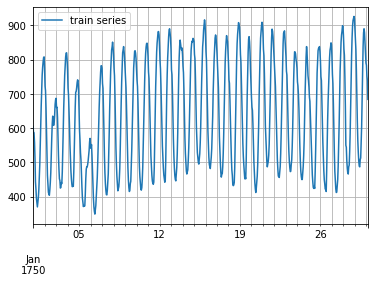

In [58]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

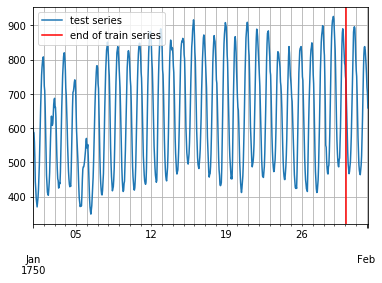

In [59]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [60]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### Custom Datasets

- requirement
    1. be iterable(iterable한 데이터 형식)
    2. have 'target' and 'start'
  
- 용어 설명
    - prediction_length = 예측 길이 즉, output으로 나오는 길이

In [105]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H" # meaning 1 hour
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

In [106]:
from gluonts.dataset.common import ListDataset

In [107]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x, 'start': start}
                        for x in custom_dataset[:, :-prediction_length]],
                       freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x, 'start': start}
                       for x in custom_dataset],
                      freq=freq)

## Training an existing model

- 용어 설명
    - `context_length`: input window length
    - `prediction_length`: predicts the disribution of the values
    - `Trainer`: definces how the model will be trained(i.e., the number of epochs, the learning rate, etc)

In [108]:
dataset.metadata.freq

'H'

In [20]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

In [109]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="gpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

In [110]:
predictor = estimator.train(dataset.train)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:01<00:00, 97.02it/s, epoch=5/5, avg_epoch_loss=4.54]


- `make_evaluation_prediction` 함수는 prediction과 evaluation을 자동화한 것
    - `dataset.test`의 마지막 부분, 즉 우리가 예측하고자 하는 부분을 제거함
    - estimator는 나머지 데이터를 사용해서 방금 제거한 'future' 윈도우를 예측함
    - 모델의 결과는 `forcast sample`과 `dataset.test`
    - 즉. 모델의 결과를 사용해서 loss, acc 등을 계산함

In [111]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [112]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [113]:
# 결과 값을 리스트의 형태로 변환
forecasts = list(forecast_it)
tss = list(ts_it)

- `tss[0][:5]`의 값과 `dataset_test_entry['target'][:5]`의 값이 같은 것을 확인 할 수 있음

In [114]:
# first entry of the time series list
ts_entry = tss[0]

In [115]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [116]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [117]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [118]:
# first entry of the forecast list
forecast_entry = forecasts[0]

- `numpy.ndarray`의 형태로 저장되어 있으며 차원은 `(num_samples, prediction length)`로 출력됨

In [138]:
print(len(forecasts))

414


In [119]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


In [120]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [651.8788  558.99066 508.53348 528.70544 524.26917 401.26102 422.8945
 430.69717 473.57465 653.9695  633.382   622.1983  729.2377  761.70233
 788.60944 937.21844 819.8522  846.98346 763.2237  779.3643  856.45374
 754.03125 807.8347  674.3723  646.961   604.71954 491.99725 523.443
 403.00638 511.25848 477.7596  537.13025 539.64557 529.81885 622.78815
 686.7688  714.0281  840.33185 818.7952  889.2721  848.04626 828.8276
 856.484   889.9369  817.1331  791.5168  691.8198  691.8818 ]
0.5-quantile (median) of the future window:
 [653.25757 565.36884 513.4435  531.94183 523.44025 395.99094 448.368
 413.5885  465.74088 616.6228  645.57086 624.6376  721.0587  774.4991
 782.6293  925.92615 826.54193 855.3245  787.92053 790.8534  874.83026
 754.47437 786.8126  671.31177 654.5132  609.209   491.89673 515.5011
 403.2665  513.29987 481.2604  521.3815  548.5034  517.5314  621.69086
 682.5248  712.7055  848.48145 825.7998  881.9761  844.39703 822.99884
 862.558   935.316   

In [121]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

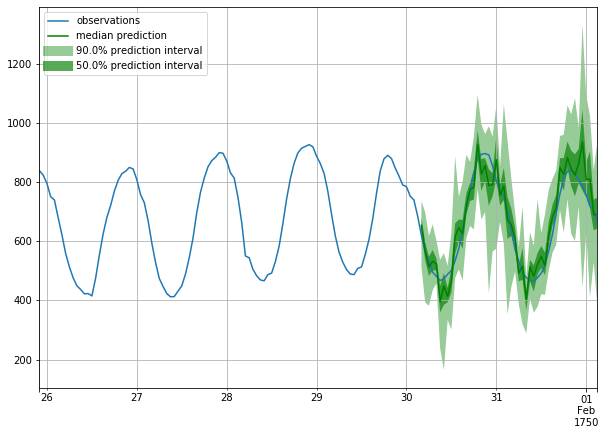

In [122]:
# prediction intervals are shaed in different colors as a 'fan chart'
plot_prob_forecasts(ts_entry, forecast_entry)

#### Evaluation
- 수치적으로 예측의 질을 측정할 수 있음
- `Evaluator` 클래스를 사용해서 결합된 성능 매트릭스를 측정할 수 있음

In [36]:
from gluonts.evaluation import Evaluator

In [37]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:04<00:00, 102.49it/s]


In [38]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 12313028.049130742,
    "abs_error": 10678433.337844849,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 3.4821289466911773,
    "MAPE": 0.2345110478879168,
    "sMAPE": 0.18090939820755192,
    "OWA": NaN,
    "MSIS": 34.4840065750996,
    "QuantileLoss[0.1]": 4135484.1516716005,
    "Coverage[0.1]": 0.11236916264090174,
    "QuantileLoss[0.5]": 10678433.111317635,
    "Coverage[0.5]": 0.5674315619967797,
    "QuantileLoss[0.9]": 7071009.858074472,
    "Coverage[0.9]": 0.8851650563607085,
    "RMSE": 3508.9924549834445,
    "NRMSE": 0.4790549770795141,
    "ND": 0.07336161518283181,
    "wQuantileLoss[0.1]": 0.028411077480290925,
    "wQuantileLoss[0.5]": 0.07336161362657335,
    "wQuantileLoss[0.9]": 0.04857835299899558,
    "mean_wQuantileLoss": 0.05011701470195329,
    "MAE_Coverage": 0.03154522275899097
}


In [39]:
# 개별 매트릭스는 타임 스탭에 따라서면 결합될 수 있음
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,3615.741211,2052.071777,31644.0,659.250000,42.371302,1.008973,0.063794,0.060768,NaN,6.352689,818.498108,0.041667,2052.071625,0.854167,1459.546484,1.000000
1,1.0,205301.333333,19939.501953,124149.0,2586.437500,165.107988,2.515967,0.164278,0.149323,NaN,20.823627,6521.856567,0.416667,19939.501465,1.000000,8473.854639,1.000000
2,2.0,21496.682292,5665.931152,65030.0,1354.791667,78.889053,1.496282,0.079301,0.083542,NaN,9.137049,3125.689233,0.000000,5665.931458,0.229167,1790.871558,0.833333
3,3.0,206092.979167,15084.420898,235783.0,4912.145833,258.982249,1.213437,0.065366,0.063331,NaN,10.867724,9754.021045,0.041667,15084.420410,0.458333,8522.352344,1.000000
4,4.0,115413.364583,12547.171875,131088.0,2731.000000,200.494083,1.303776,0.092573,0.086692,NaN,7.234886,4064.694141,0.041667,12547.171997,0.791667,6940.073242,1.000000


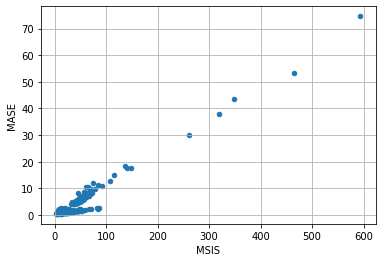

In [40]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

## Creating own forecast model

- 예측 모델을 위해서는 다음의 것들이 필요함:
    - training and prediction network를 정의해야 함
    - 데이터 처리를 구체화 하고 네트워크를 사용하는 새로운 estimator를 정의해야 함
    
- trainin and prediction network에 필요한 것:
    - training and prediction network의 `hybrid_forward` 메소드 : 네트워크가 호출되면 무엇을 할지 정하는 메소드
    - training network의 `hybrid_forward` 는 예측한 값과 실제 값을 기반한 오차를 return해야 함
    - prediction network의 `hybrid_forward`는 prediction값을 return해야 함
    
- 예시
    - input = past values of the time series
    - output = future predicted window of length `prediction_length`

In [50]:
class MyTrainNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

In [51]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter
from gluonts.dataset.field_names import FieldName
from mxnet.gluon import HybridBlock

- estimator를 건설하기 위한 규칙은 다음과 같음:
    - `create_transformation` 메소드를 포함해야 함. 해당 메소드는 모든 가능한 특징들을 정의하고 훈련과정에서 데이터를 어떻게 나눌지 정의함
    - `create_training_network` 메소드를 포함해야 함. 해당 메소드는 필요한 하이퍼 파라미로 설계된 훈련 네트워크를 return함
    - `create_predictor` 메도스를 포함해야 함. 해당 메소드는 prediction 네트워크를 생성하고 `Predictor` 객체를 return함
    
- `Predictor`는 주어진 predictor의 `predict` 메소드를 정의함
    - 이 메소드는 테스트 데이터셋을 사용하고 prediction network를 지나 예측을 생성함
    - `Predictor` 객체를 `predict`메소드를 정의하는 prediction network의 wrapper라고 생각해도 됨
    
- 내부적으로 `make_evaluation_predictions` 함수는 predictor의 `predict` 메소드를 예측을 위해 촉진함 

In [52]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        freq: str,
        context_length: int,
        prediction_length: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.freq = freq


    def create_transformation(self):
        # Feature transformation that the model uses for input.
        # Here we use a transformation that randomly select training samples from all time series.
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [141]:
estimator = MyEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu",
                    epochs=7,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

In [142]:
predictor = estimator.train(dataset.train)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:01<00:00, 98.23it/s, epoch=7/7, avg_epoch_loss=759]


In [143]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
    num_samples=100
)

In [144]:
forecasts = list(forecast_it)
tss = list(ts_it)

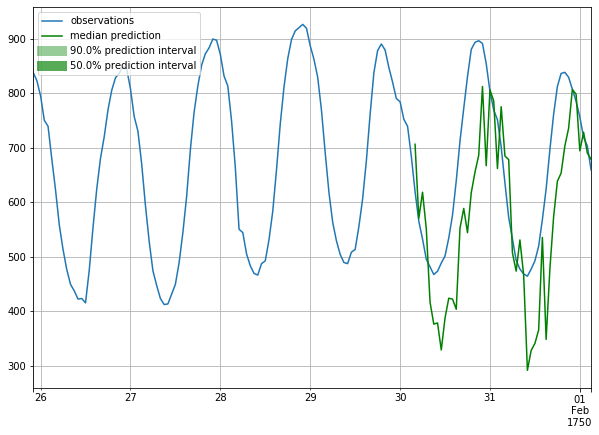

In [145]:
plot_prob_forecasts(tss[0], forecasts[0])

In [97]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:04<00:00, 100.62it/s]


In [98]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 22950571.00395863,
    "abs_error": 15249719.199466705,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 7.244522384863081,
    "MAPE": 0.5396603365408058,
    "sMAPE": 0.25345231181681793,
    "OWA": NaN,
    "MSIS": 289.7808999946937,
    "QuantileLoss[0.1]": 7572826.070560265,
    "Coverage[0.1]": 0.3583937198067634,
    "QuantileLoss[0.5]": 15249719.01941204,
    "Coverage[0.5]": 0.3583937198067634,
    "QuantileLoss[0.9]": 22926611.96826382,
    "Coverage[0.9]": 0.3583937198067634,
    "RMSE": 4790.6754225222385,
    "NRMSE": 0.6540330120893949,
    "ND": 0.1047666821679393,
    "wQuantileLoss[0.1]": 0.0520258669467971,
    "wQuantileLoss[0.5]": 0.10476668093095064,
    "wQuantileLoss[0.9]": 0.1575074949151042,
    "mean_wQuantileLoss": 0.10476668093095065,
    "MAE_Coverage": 0.3138687600644122
}


In [99]:
item_metrics.head(10)

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,6.687465e+03,3302.971924,31644.0,659.250000,42.371302,1.624022,0.108485,0.115641,NaN,64.960868,2062.194421,0.333333,3302.972107,0.333333,4543.749792,0.333333
1,1.0,1.254642e+05,13587.521484,124149.0,2586.437500,165.107988,1.714474,0.113527,0.106623,NaN,68.578965,21448.168945,0.750000,13587.521484,0.750000,5726.874023,0.750000
2,2.0,1.172037e+05,13971.759766,65030.0,1354.791667,78.889053,3.689718,0.199543,0.227330,NaN,147.588700,3079.397559,0.041667,13971.760254,0.041667,24864.122949,0.041667
3,3.0,4.237106e+05,26304.916016,235783.0,4912.145833,258.982249,2.116049,0.115293,0.124444,NaN,84.641952,11710.750537,0.250000,26304.916748,0.250000,40899.082959,0.250000
4,4.0,1.195419e+05,13552.654297,131088.0,2731.000000,200.494083,1.408256,0.106971,0.113912,NaN,56.330229,6265.092432,0.270833,13552.653564,0.270833,20840.214697,0.270833
5,5.0,5.840576e+05,28774.486328,303379.0,6320.395833,212.875740,2.816049,0.092041,0.098504,NaN,112.641955,10938.313770,0.291667,28774.486816,0.291667,46610.659863,0.291667
6,6.0,3.325352e+07,245058.562500,1985325.0,41360.937500,1947.687870,2.621255,0.122627,0.132809,NaN,104.850208,60114.006641,0.083333,245058.564453,0.083333,430003.122266,0.083333
7,7.0,2.226407e+07,193708.406250,1540706.0,32098.041667,1624.044379,2.484902,0.124999,0.136154,NaN,99.396106,61140.899023,0.145833,193708.416992,0.145833,326275.934961,0.145833
8,8.0,1.223443e+07,132693.531250,1640860.0,34184.583333,1850.988166,1.493499,0.083376,0.085717,NaN,59.739948,114509.071484,0.416667,132693.529297,0.416667,150877.987109,0.416667
9,9.0,3.950135e+03,2631.551514,21408.0,446.000000,10.526627,5.208125,0.121482,0.131640,NaN,208.325002,703.066357,0.125000,2631.551514,0.125000,4560.036670,0.125000


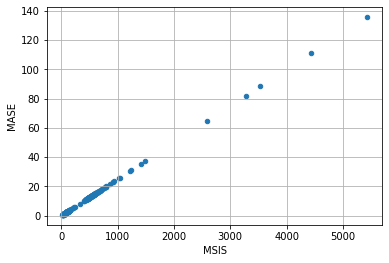

In [100]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()